In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from scipy.spatial import Delaunay

# ------------------------------------------------------------------
# 1) Load mesh: top, mid, bottom nodes
# ------------------------------------------------------------------
def load_mesh(mesh_dir="Mesh"):
    pts = np.loadtxt(f"{mesh_dir}/midconf_PointsN99.txt")
    x, y = pts[:,0], pts[:,1]
    # top boundary
    top_id = np.where(y > 1.9)[0]
    tx = np.sort(x[top_id])
    NT = len(tx) + 1
    Top0 = np.zeros((NT,2)); Top0[:,1] = 3.0
    Top0[0,0], Top0[-1,0] = 0.0, 7.0
    for i in range(len(tx)-1):
        Top0[i+1,0] = 0.5*(tx[i]+tx[i+1])
    # bottom boundary
    bot_id = np.where(y < 0.1)[0]
    bx = np.sort(x[bot_id])
    NB = len(bx) + 1
    Bottom0 = np.zeros((NB,2)); Bottom0[:,1] = -1.0
    Bottom0[0,0], Bottom0[-1,0] = 0.0, 7.0
    for i in range(len(bx)-1):
        Bottom0[i+1,0] = 0.5*(bx[i]+bx[i+1])
    # interior midpoints
    Mid0 = pts.copy()
    return Top0, Mid0, Bottom0

# ------------------------------------------------------------------
# 2) Elastic force on midpoints (interior triangles)
# ------------------------------------------------------------------
def elastic_force(triangles, X0, X, kk, gamma):
    N = X.shape[0]
    Fc = np.zeros((N,2))
    dA = np.zeros(N)
    # accumulate per-vertex area
    for i1,i2,i3 in triangles:
        x1,y1 = X[i1]; x2,y2 = X[i2]; x3,y3 = X[i3]
        area = 0.5*((x2-x1)*(y3-y1)-(y2-y1)*(x3-x1))
        for idx in (i1,i2,i3):
            dA[idx] += area/3
    # build unique edges
    edges = set()
    for t in triangles:
        a,b,c = t
        edges |= {
            tuple(sorted((a,b))),
            tuple(sorted((b,c))),
            tuple(sorted((c,a))),
        }
    # for each edge apply spring
    for i1,i2 in edges:
        r0 = X0[i2]-X0[i1]; r  = X[i2]-X[i1]
        dl0 = np.linalg.norm(r0); dl = np.linalg.norm(r)
        if dl0==0 or dl==0: 
            continue
        avgA = 0.5*(dA[i1]+dA[i2])
        dk   = (8*kk/(3*dl0))*avgA
        factor = gamma + (dk/avgA)*(dl/dl0 - 1.0)
        u = r/dl
        Fc[i1] +=  factor*u
        Fc[i2] += -factor*u  # Newton’s third law, that spring must push/pull equally and oppositely on its two endpoints
    return Fc

# ------------------------------------------------------------------
# 3) Cross‐interface springs Top↔Mid
# ------------------------------------------------------------------
def crossTopElements(Top0, Top, Mid0, Mid, kk, gamma, tri_all):
    NT = Top.shape[0]
    MT = Mid.shape[0]
    F_top = np.zeros_like(Top)
    F_mid = np.zeros_like(Mid)
    edges = set()
    # pick edges from the full Delaunay that cross between Top and Mid
    for t in tri_all:
        for (i,j) in ((t[0],t[1]),(t[1],t[2]),(t[2],t[0])):
            if i < NT <= j < NT+MT:
                edges.add((i, j-NT))
            elif j < NT <= i < NT+MT:
                edges.add((j, i-NT))
    # apply the same spring law
    for iT, iM in edges:
        r0 = Mid0[iM] - Top0[iT]
        r  = Mid[iM]  - Top[iT]
        dl0 = np.linalg.norm(r0); dl = np.linalg.norm(r)
        if dl0==0 or dl==0:
            continue
        # we’ll omit area‐weighting for boundary springs
        dk = kk
        factor = gamma + dk*(dl/dl0 - 1.0)
        u = r/dl
        F_top[iT] +=  factor*u
        F_mid[iM] += -factor*u
    return F_top, F_mid

# ------------------------------------------------------------------
# 4) Cross‐interface springs Bottom↔Mid
# ------------------------------------------------------------------
def crossBottomElements(Bottom0, Bottom, Mid0, Mid, kk, gamma, tri_all, NT, MT):
    NB = Bottom.shape[0]
    F_bot = np.zeros_like(Bottom)
    F_mid = np.zeros_like(Mid)
    edges = set()

    offset_mid = NT
    offset_bot = NT + MT
    # pick the Mid–Bottom interface edges
    for t in tri_all:
        for (i, j) in ((t[0],t[1]), (t[1],t[2]), (t[2],t[0])):
            if offset_mid <= i < offset_mid + MT and j >= offset_bot:
                edges.add((i - offset_mid, j - offset_bot))
            elif offset_mid <= j < offset_mid + MT and i >= offset_bot:
                edges.add((j - offset_mid, i - offset_bot))

    # apply the same spring law—but flipped so bottom is pulled toward mid
    for iM, iB in edges:
        # note: r0 and r now point from bottom→mid (instead of mid→bottom)
        r0 = Mid0[iM]   - Bottom0[iB]
        r  = Mid[iM]    - Bottom[iB]
        dl0 = np.linalg.norm(r0)
        dl  = np.linalg.norm(r)
        if dl0 == 0 or dl == 0:
            continue
        dk = kk
        factor = gamma + dk * (dl/dl0 - 1.0)
        u = r / dl

        # **pull** Bottom toward Mid, Mid toward Bottom
        F_bot[iB] +=   factor * u
        F_mid[iM] +=  -factor * u
    return F_bot, F_mid

# ------------------------------------------------------------------
# 5) Boundary-to-boundary springs Top↔Top and Bottom↔Bottom
# ------------------------------------------------------------------
def boundarySpringElements(Bound0, Bound, kk, gamma):
    """
    Connect each consecutive pair of boundary nodes with a spring:
      - Bound0  : original positions (Nx2)
      - Bound   : current positions (Nx2)
      - kk      : spring constant
      - gamma   : damping‐style offset
    Returns:
      F_bound  : (N×2) forces on each boundary node
    """
    N = Bound.shape[0]
    F = np.zeros_like(Bound)
    # build edges between i and i+1
    for i in range(N-1):
        j = i+1
        r0 = Bound0[j] - Bound0[i]
        r  = Bound[j]  - Bound[i]
        dl0 = np.linalg.norm(r0)
        dl  = np.linalg.norm(r)
        if dl0 == 0 or dl == 0:
            continue
        # same law as cross interface: dk = kk, factor = γ + kk*(dl/dl0 - 1)
        factor = gamma + kk*(dl/dl0 - 1.0)
        u = r / dl
        F[i]   +=  factor * u
        F[j]   += -factor * u
    return F

# ------------------------------------------------------------------
# 6) Compute Traction Forces
# ------------------------------------------------------------------

def compute_traction_forces(F_topX, F_topB, F_botX, F_botB, F_mid_total, pinned, Mid, center):
    """
    Given the two spring contributions on top & bottom, compute:
      F_tl = top-left vertical force
      F_tr = top-right vertical force
      F_bl = bottom-left vertical force
      F_br = bottom-right vertical force
      F_sum = sum of lefts + abs(rights)
    """
    F_top = F_topX + F_topB     # (NT×2)
    F_bot = F_botX + F_botB     # (NB×2)

    # --- classify side-pinned mid-nodes into 4 quadrants ---
    # get coords and center
    xs = Mid[:,0]
    ys = Mid[:,1]
    cx, cy = center
    p = pinned  # array of indices into Mid

    # boolean masks over the pinned indices
    is_top    = ys[p] >  cy
    is_bottom = ~is_top
    is_left   = xs[p] <  cx
    is_right  = ~is_left

    tl_idx = p[ is_top    & is_left ]
    tr_idx = p[ is_top    & is_right]
    bl_idx = p[ is_bottom & is_left ]
    br_idx = p[ is_bottom & is_right]

    # vertical component at the two ends:
    F_tl = F_top[0,0]
    F_tr = F_top[-1,0]
    F_bl = F_bot[0,0]
    F_br = F_bot[-1,0]

    # vertical force on each group:
    # for top‐side traction we take –y; bottom we take +y
    extra_tl =  np.sum(F_mid_total[tl_idx,0])
    extra_tr =  np.sum(F_mid_total[tr_idx,0])
    extra_bl =  np.sum(F_mid_total[bl_idx,0])
    extra_br =  np.sum(F_mid_total[br_idx,0])

    # ── combine each extra into its corner ──
    F_tl_total = F_tl + extra_tl
    F_tr_total = abs(F_tr + extra_tr)
    F_bl_total = F_bl + extra_bl
    F_br_total = abs(F_br + extra_br)
    
    F_sum = F_tl_total + F_tr_total + F_bl_total + F_br_total
    return F_tl_total, F_tr_total, F_bl_total, F_br_total, F_sum

# ---------- port of MATLAB “nuclearForce” ----------
def nuclear_force(X0, X, k, gamma, k_cell, A0):
    """
    Membrane + pressure forces on a closed nuclear ring.
    Inputs/outputs follow the MATLAB version almost verbatim.
    """
    N = X0.shape[0]                 # number of boundary vertices

    # ---- characteristic spacing (mean edge length) ----
    ds  = np.mean(np.linalg.norm(X[2:] - X[1:-1], axis=1))

    # ---- forward / backward edges (current & rest) ----
    fwd0 = np.roll(X0,-1,axis=0) - X0
    bwd0 = np.roll(X0, 1,axis=0) - X0
    fwd  = np.roll(X ,-1,axis=0) - X
    bwd  = np.roll(X , 1,axis=0) - X  

    lp0 = np.linalg.norm(fwd0, axis=1); lp0[lp0==0] = 1          # avoid /0
    lm0 = np.linalg.norm(bwd0, axis=1); lm0[lm0==0] = 1
    lp  = np.linalg.norm(fwd , axis=1); lp [lp ==0] = 1
    lm  = np.linalg.norm(bwd , axis=1); lm [lm ==0] = 1

    term1 = (gamma + k*(lp/lp0 - 1))[:,None] * (fwd / lp[:,None])
    term2 = (gamma + k*(lm/lm0 - 1))[:,None] * (bwd / lm[:,None])
    Fe    = term1 + term2                         # elastic part

    # ---- pressure part ----
    p0  = compute_p0_term(X, Fe)                  # see helper
    A   = polygon_area(X)
    #p   = p0 + k_cell*np.log(A0 / A)
    p_raw = p0 + k_cell*np.log(A0/A)          # original formula
    p_max = k*0.8                           # 0.8                  <-- new
    p = np.clip(p_raw, -p_max, p_max)         #                      <-- new
    Fp  = compute_pressure_forces(X, p)

    F = (Fe + Fp*ds) / ds                        # MATLAB: add, then rescale
    
    return F

# ---------- port of MATLAB “nucleusnetworkForces” ----------
def nucleus_network_forces(k, g, MidNodes, NucNode,
                            MidNodes0, NucNode0):
    """
    Springs connecting *one* nuclear vertex to its nn nearest Mid vertices.
    MidNodes shape == (nn,2); returns:
       F_mid  : (nn,2) forces on those Mid vertices
       F_nuc  : ( 1,2) reaction on the nuclear vertex
    """
    dl0 = np.linalg.norm(MidNodes0 - NucNode0, axis=1)
    dl  = np.linalg.norm(MidNodes  - NucNode , axis=1)
    dl [dl ==0]  = 1         # guard against division by zero
    fac = (g + k*(dl/dl0 - 1))
    u   = (NucNode - MidNodes)/dl[:,None]
    F_mid = fac[:,None] * u          # pull Mid → Nucleus
    F_nuc = -F_mid.sum(axis=0)
    return F_mid, F_nuc              # shapes: (nn,2), (1,2)

# ---------- geometry & pressure helpers ----------
def polygon_area(X):
    """Signed area of a closed polygon, X shape (N,2)."""
    return 0.5*np.sum(X[:,0]*np.roll(X[:,1],-1) - X[:,1]*np.roll(X[:,0],-1))

def polygon_area_gradient(X):
    """
    ∂A/∂x_i , ∂A/∂y_i   (the exact gradient of area wrt vertices).
    dA/dx_i = (y_{i+1} - y_{i-1})/2
    dA/dy_i = (x_{i-1} - x_{i+1})/2
    """
    dx = (np.roll(X[:,1],-1) - np.roll(X[:,1], 1))*0.5
    dy = (np.roll(X[:,0], 1) - np.roll(X[:,0],-1))*0.5
    return np.column_stack([dx, dy])

def compute_p0_term(X, Fe):
    """
    Choose p₀ so that the *total* force on the nucleus remains zero
    (standard trick in many vertex‑models).
    """
    gradA = polygon_area_gradient(X)
    num   = np.sum((Fe*gradA).sum(axis=1))      # Σ_i  Fe_i ⋅ ∇_i A
    den   = np.sum((gradA*gradA).sum(axis=1))   # Σ_i |∇_i A|²
    return 0.0 if den==0 else -num/den

def compute_pressure_forces(X, p):
    """
    Force on each vertex resulting from *uniform* internal pressure p
    equals p * gradient of area.
    """
    return p * polygon_area_gradient(X)

In [15]:
# ------------------------------------------------------------------
# Helper for force‑vs‑time plots with a side legend
# ------------------------------------------------------------------
def plot_force_family(t, F_hist, coords, title, ax=None,
                      cmap='tab20', legend_title='x‑pos'):
    """
    t         : (steps,)      time axis
    F_hist    : (steps, N)    forces for N nodes
    coords    : (N,)          x locations (or any label you like)
    title     : str           panel title
    ax        : matplotlib axis (optional)
    cmap      : matplotlib colormap name
    legend_title : str
    """
    import matplotlib as mpl
    if ax is None:
        ax = plt.gca()

    N = F_hist.shape[1]
    colors = mpl.cm.get_cmap(cmap, N)

    for i in range(N):
        label = f'{coords[i]:.2f}'
        ax.plot(t, F_hist[:, i],
                color=colors(i),  lw=1.2, alpha=0.9,
                label=label)

    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Force')
    ax.grid(True)

    # side legend – outside the right margin
    ax.legend(title=legend_title,
              bbox_to_anchor=(1.02, 1.00),
              loc='upper left', borderaxespad=0.)

Saved cut_vimentin_cut_actin_no_recirc.mp4


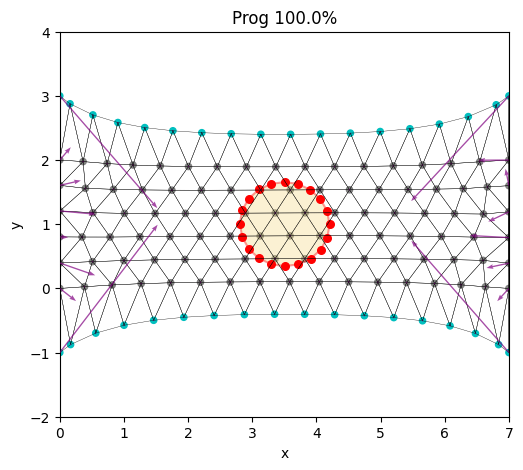

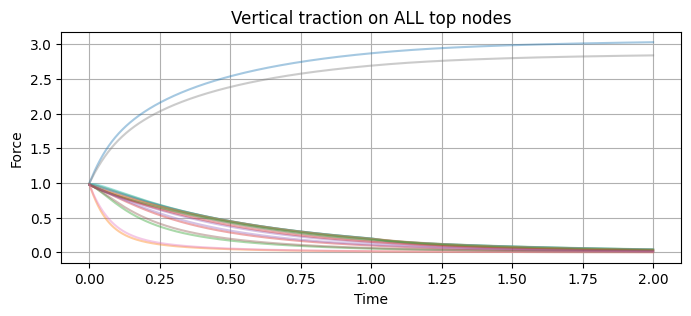

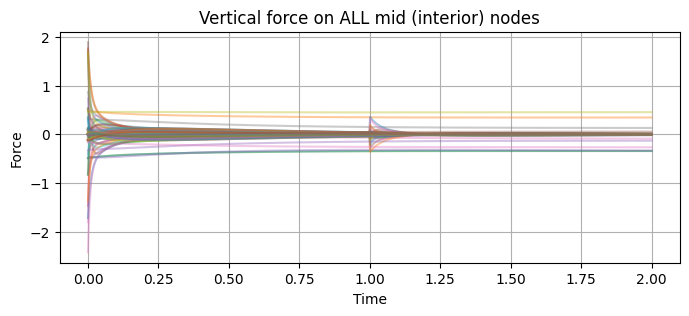

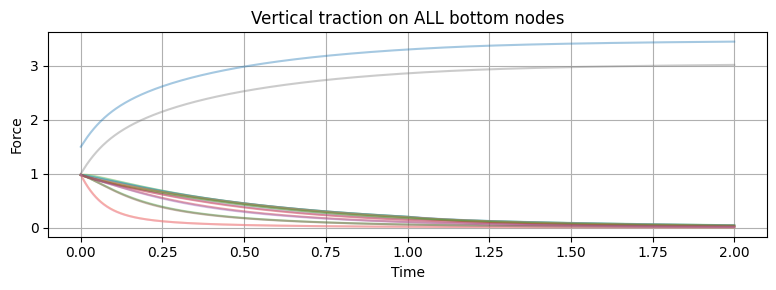

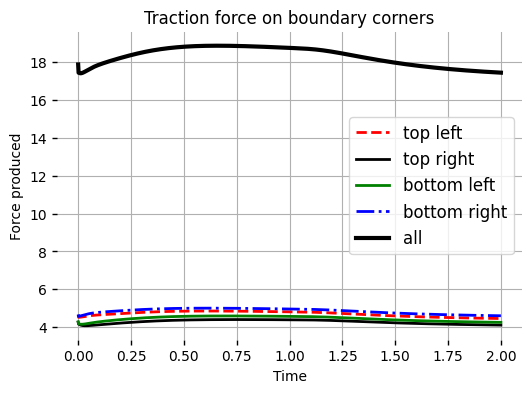

In [16]:
# REMOVE NUCLEUS-CYTOSKELETON CONNECTION AFTER SHRINKING
# ------------------------------------------------------------------
# 7) Setup parameters & initialize
condition = "cut_vimentin_cut_actin_no_recirc"
# ------------------------------------------------------------------
# ---- timing -------------------------------------------------------
T_shrink        = 1        # 2 seconds spent shrinking
T_relax         = 1        # 1 seconds after detachment
dt              = 2e-3       # 2e-3 time step
Tmax            = T_shrink + T_relax
steps           = int(Tmax/dt)

kk_m, g_m = 1.0, 0.5      # interior springs            1.0, 0.05
kk_c, g_c = 1.0, 0.5      # cross‐interface springs     0.5, 0.02 
kk_b, g_b = 20.0, 2.0      # boundary springs            20.0, 2.0
xlim, ylim = (0,7),(-2,4)

Top0, Mid0, Bottom0 = load_mesh("Mesh")
NT, MT, NB = len(Top0), len(Mid0), len(Bottom0)
all0 = np.vstack([Top0, Mid0, Bottom0])    # basically stacks up Top0, Mid0 and Bottom0
tri_all = Delaunay(all0).simplices
Tri_mid = np.loadtxt("Mesh/midconf_TrianglesN99.txt",dtype=int)-1

# radial distances for shrink
center = Mid0.mean(axis=0)    # averages by column --> results in an averaged point x, y 
d0 = np.linalg.norm(all0-center,axis=1)    # computes norm by row --> results in a list of norms 
maxd = d0.max()
d0_top = d0[:NT]
d0_mid = d0[NT:NT+MT]
d0_bot = d0[NT+MT:]
# pinned mid‐nodes at left & right sides
xs = Mid0[:,0]
pinned = np.where((np.isclose(xs,xs.min()))|(np.isclose(xs,xs.max())))[0]  # indices in Mid0 where there are edge nodes

# nucleus ring
r_nucl = 0.75 #0.75
th = np.linspace(0,2*np.pi,21)[:-1]
Xn0 = np.column_stack([center[0] + r_nucl*np.cos(th), center[1] + r_nucl*np.sin(th)])
center0 = Xn0.mean(axis=0)        # right after you build Xn0

# figure & video writer
fig,ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal','box')
writer = FFMpegWriter(fps=30)
writer.setup(fig,f'{condition}.mp4',dpi=150)

# initial positions
Top    = Top0.copy()
Mid    = Mid0.copy()
Bottom = Bottom0.copy()

# prepare lists to record
F_tl_list = []
F_tr_list = []
F_bl_list = []
F_br_list = []
F_sum_list = []
F_top_hist = []      # will hold shape (steps, NT)
F_mid_hist = []      # will hold shape (steps, MT)
F_bot_hist = []      # will hold shape (steps, NB)

# ------------------------------------------------------------------
# NUCLEUS: parameters, rest area, neighbour table       
# # larger gamma adds a constant contractile tension           
# # larger k makes the ring fight harder to reach the shrinking rest length you already feed it
# # smaller k_cell reduces the outward pressure that opposes contraction
# ------------------------------------------------------------------
k_n, g_n        =  10.0,  1     # 5.0,  0.5 membrane spring & offset
k_cell          =  1           # 0.1 bulk modulus (pressure term)
k_attach, g_attach =  10.0, 1   # 1.0, 0.2 springs Nucleus ↔ Mid                4.0, 0.2
nn_attach       = 3              # how many Mid neighbours per vertex

# dynamic positions
Xn  = Xn0.copy()                 # current ring vertices
A0_n = polygon_area(Xn0)         # polygon_area(Xn0) rest area

# for every nuclear vertex, pre‑store the idx of its 3 nearest Mid nodes
from scipy.spatial import cKDTree
tree_mid = cKDTree(Mid0)
mid_neigh_idx = np.array([
    tree_mid.query(Xn0[i], k=nn_attach)[1]        # shape (nn,)
    for i in range(Xn0.shape[0])
])

# ------------------------------------------------------------------
# 8) Animation loop
# ------------------------------------------------------------------
for step in range(steps):
    t              = step*dt                 # current time
    shrink_prog    = min(t / T_shrink, 1.0)  # 0→1 during shrink, stays 1 afterwards             1.0
    prog = shrink_prog                       # for the traction‑history bookkeeping later
    attachments_active = shrink_prog < 1.0   # True while still shrinking

    # interior elastic
    Fm = elastic_force(Tri_mid, Mid0, Mid, kk_m, g_m)           # before we had -- Fm[pinned] = 0

    # cross‐interface elastic
    F_topX, F_midX1 = crossTopElements(Top0, Top, Mid0, Mid, kk_c, g_c, tri_all)
    F_botX, F_midX2 = crossBottomElements(Bottom0, Bottom, Mid0, Mid, kk_c, g_c,
                                          tri_all, NT, MT)
    
    # ------------------------------------------------------------------
    # NUCLEUS forces
    # ------------------------------------------------------------------
    # 3a. membrane + pressure on the ring itself
    F_nuc_mem = nuclear_force(Xn0, Xn, k_n, g_n, k_cell, A0_n)
    # 3b. (optional) springs that tether each nuclear vertex to its Mid neighbours
    if attachments_active:
        F_mid_attach = np.zeros_like(Mid)
        F_nuc_attach = np.zeros_like(Xn)
        for iv in range(Xn.shape[0]):
            mid_ids = mid_neigh_idx[iv]
            Fm_i, Fn_i = nucleus_network_forces(k_attach, g_attach,
                                                Mid[mid_ids], Xn[iv],
                                                Mid0[mid_ids], Xn0[iv])
            F_mid_attach[mid_ids] += Fm_i
            F_nuc_attach[iv]      += Fn_i
    else:                                   # after detachment
        F_mid_attach = 0.0
        F_nuc_attach = 0.0

    # total forces
    F_mid_total = Fm + F_midX1 + F_midX2 + F_mid_attach
    F_nuc_total = F_nuc_mem + F_nuc_attach

    # new: boundary springs
    F_topB = boundarySpringElements(Top0,    Top,    kk_b, g_b)
    F_botB = boundarySpringElements(Bottom0, Bottom, kk_b, g_b)

    # record traction this step                                
    f_tl, f_tr, f_bl, f_br, f_sum = compute_traction_forces(F_topX, F_topB, F_botX, F_botB, F_mid_total, pinned, Mid, center)
    F_tl_list.append(f_tl)
    F_tr_list.append(f_tr)
    F_bl_list.append(f_bl)
    F_br_list.append(f_br)
    F_sum_list.append(f_sum)

    # total instantaneous forces on each node
    F_top = F_topX + F_topB            # shape (NT,2)
    F_bot = F_botX + F_botB            # shape (NB,2)

    # record vertical component: 
    F_top_hist.append((-F_top[:,1]).copy())  
    F_bot_hist.append(( F_bot[:,1]).copy())  
    F_mid_hist.append((F_mid_total[:,1]).copy())

    # integrate with ALL forces
    Top    += dt*(F_topX + F_topB)
    Bottom += dt*(F_botX + F_botB)

    Mid[pinned] = Mid0[pinned]

    Mid    += dt*F_mid_total
    Xn     += dt*F_nuc_total
    
    # **clamp the corner positions back to their originals**
    Top[0]    = Top0[0]
    Top[-1]   = Top0[-1]
    Bottom[0] = Bottom0[0]
    Bottom[-1]= Bottom0[-1]

    # draw mesh + nucleus
    cur = np.vstack([Top, Mid, Bottom])
    ax.clear()
    for tri in tri_all:
        pts = cur[tri]
        ax.plot(pts[[0,1],0], pts[[0,1],1], 'k-', linewidth=0.25)
        ax.plot(pts[[1,2],0], pts[[1,2],1], 'k-', linewidth=0.25)
        ax.plot(pts[[2,0],0], pts[[2,0],1], 'k-', linewidth=0.25)
    ax.scatter(cur[:,0], cur[:,1], c=['c']*NT + ['gray']*MT + ['c']*NB, s=20)

    # ── draw the *fixed* nucleus‑to‑mesh springs ──
    if attachments_active:                       # skip when detached
        for iv, p in enumerate(Xn):
            for q in Mid[mid_neigh_idx[iv]]:     # ← pre‑stored partners
                ax.plot([p[0], q[0]], [p[1], q[1]],
                        linestyle='--', linewidth=0.8, color='green')

    poly = plt.Polygon(Xn, facecolor='#f5de91', edgecolor='red', lw=1.5, alpha=0.4)
    ax.add_patch(poly)
    ax.scatter(Xn[:,0], Xn[:,1], c='r', s=30)

    ### QUIVER ###
    arrow_len_max = 0.5      # length (data units) of every quiver arrow
    # --- assemble positions and force vectors -------------------
    pos   = np.vstack([Top, Mid, Bottom])           # (NT+MT+NB, 2)
    force = np.vstack([F_top, F_mid_total, F_bot])  # same shape

    # --- normalise every vector -------------------------------
    mags = np.linalg.norm(force, axis=1)             #  (NT+MT+NB,)
    mag_ref = np.percentile(mags, 95) + 1e-12        # 1e‑12 to avoid /0
    scale_fac = arrow_len_max / mag_ref              # data‑units per Newton
    U = force[:, 0] * scale_fac
    V = force[:, 1] * scale_fac

    # --- draw the quiver ---------------------------------------
    ax.quiver(pos[:, 0], pos[:, 1], U, V,
              angles='xy', scale_units='xy', scale=1,
              width=0.003, headwidth=3.5, headlength=5,
              color='purple', alpha=0.7, zorder=4)
    ### QUIVER ###

    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    ax.set_xlabel('x'); ax.set_ylabel('y')
    ax.set_title(f"Prog {100*shrink_prog:.1f}%")
    writer.grab_frame()

writer.finish()
print(f"Saved {condition}.mp4")


# convert lists → arrays
F_top_hist = np.vstack(F_top_hist)    # (steps, NT)
F_mid_hist = np.vstack(F_mid_hist)    # (steps, MT)
F_bot_hist = np.vstack(F_bot_hist)    # (steps, NB)

t = np.linspace(0, Tmax, F_top_hist.shape[0])

# --- Plot all top‐boundary nodes ---
plt.figure(figsize=(8,3))
for i in range(F_top_hist.shape[1]):
    plt.plot(t, F_top_hist[:,i], alpha=0.4)
plt.title('Vertical traction on ALL top nodes')
plt.xlabel('Time'); plt.ylabel('Force')
plt.grid(True)

# --- Plot all mid‐nodes ---
plt.figure(figsize=(8,3))
for i in range(F_mid_hist.shape[1]):
    plt.plot(t, F_mid_hist[:,i], alpha=0.4)
plt.title('Vertical force on ALL mid (interior) nodes')
plt.xlabel('Time'); plt.ylabel('Force')
plt.grid(True)

# --- Plot all bottom‐boundary nodes ---
plt.figure(figsize=(8,3))
for i in range(F_bot_hist.shape[1]):
    plt.plot(t, F_bot_hist[:,i], alpha=0.4)
plt.title('Vertical traction on ALL bottom nodes')
plt.xlabel('Time'); plt.ylabel('Force')
plt.grid(True)

plt.tight_layout()
plt.show()


# once the movie is done (or even alongside), plot the traction history:
t = np.linspace(0, Tmax, len(F_tl_list))

plt.figure(figsize=(6,4))
plt.plot(t, F_tl_list,   '--', linewidth=2, label='top left',   color='r')
plt.plot(t, np.abs(F_tr_list), '-', linewidth=2, label='top right',  color='k')
plt.plot(t, F_bl_list,   '-', linewidth=2, label='bottom left',color='g')
plt.plot(t, np.abs(F_br_list),'-.',linewidth=2, label='bottom right',color='b')
plt.plot(t, F_sum_list,  '-k', linewidth=3, label='all')

plt.xlabel('Time');    plt.ylabel('Force produced')
plt.legend(fontsize=12)
plt.grid(True);  plt.box(False)
plt.gca().tick_params(direction='out', width=1)
plt.gcf().patch.set_facecolor('w')
plt.title('Traction force on boundary corners')
plt.show()

In [18]:
from IPython.display import Video

# For a local video file
Video(f"{condition}.mp4")   # mesh_sim.mp4

# If you encounter issues, try embedding the video directly
# Video("your_video.mp4", embed=True)